In [11]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
import itertools
import matplotlib.patches as mpatches
from scipy.signal import find_peaks

In [12]:
def find_local_extrema(x, f_x, window, p, extreme):
    ## Find local minima/maxima in f(x)

    # Apply a simple moving average to smooth the curve
    smoothed_f_x = np.convolve(f_x, np.ones(window)/window, mode='valid')
        
    # Adjust x accordingly
    diff = len(f_x) - len(smoothed_f_x)
    smoothed_x = x[int(diff/2) : int(diff/2)+len(smoothed_f_x)]

    # subset every N-th
    N = 1
    sub_smoothed_f_x = smoothed_f_x[0::N]
    sub_smoothed_x = smoothed_x[0::N].reset_index()['start']

    # Find peaks in the negative gradient, which correspond to local minima
    if extreme == 'min':
        minima_indices, _ = find_peaks(-sub_smoothed_f_x, prominence=p)
    elif extreme == 'max':    
        minima_indices, _ = find_peaks(sub_smoothed_f_x, prominence=p)
    else:
        print('you requested invalid extremum! Can be min or max')

    # Extract x values corresponding to the minima
#     minima_x = smoothed_x[minima_indices]
    return sub_smoothed_x, sub_smoothed_f_x, minima_indices

In [90]:
# Load ALL data
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
dbs = ['vidMac', 'vidCha', 'anoImb', 'indInd', 'picPub', 'molAte', 'agePho', 'taeGut', 'poeAcu']

all_DFs = {}
i = 0
for db in dbs:
    file_name = 'OmegaPlus_{}/intersect.LR.pi.depth.omega.bed'.format(db)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_DFs[db] = df


In [98]:
# Compute overall stats
df = all_DFs['vidMac']
temp_df = df.groupby('scaffold', as_index=False).mean()[['scaffold', 'omega']]
temp_df['db'] = [db] * df.shape[0]

,scaffold,omega
0,CM044060.1,1.574795
1,CM044061.1,1.509343
2,CM044062.1,1.572985
3,CM044063.1,1.453966
4,CM044064.1,1.513124
5,CM044065.1,1.623349
6,CM044068.1,2.212428
7,CM044069.1,1.598929
8,CM044070.1,1.451070
9,CM044071.1,1.444593


4.0316344480000135


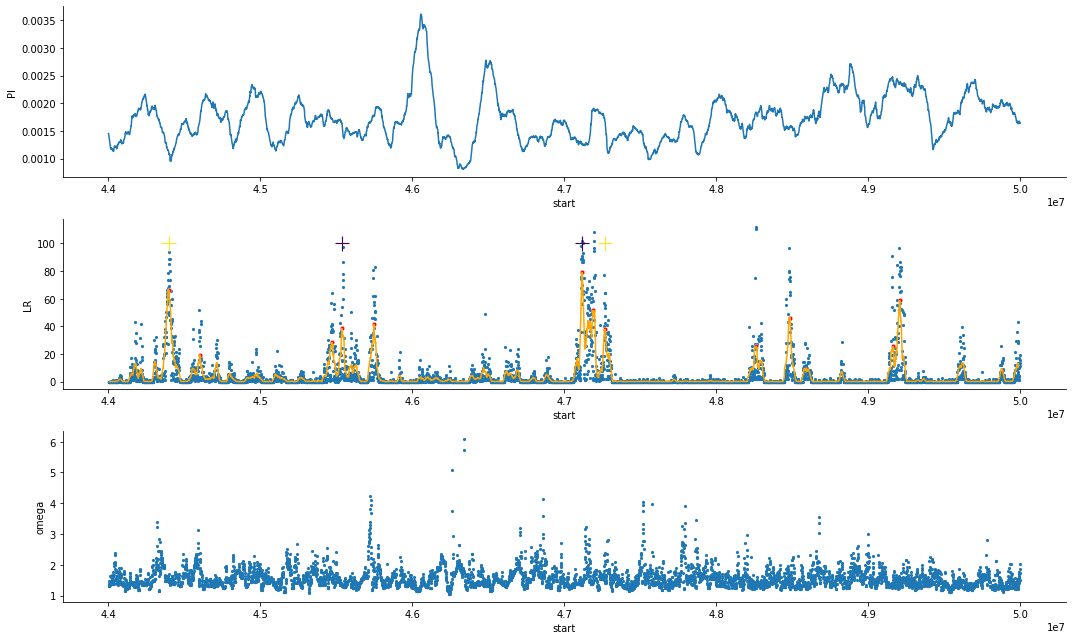

In [89]:
# OmegaPlus LD analysis

## Plot 4Mb regions of a chr


C = 'CM049527'
n = 44
df = df_full[(df_full['scaffold'] == C) & (df_full['start'] > n*10**6) & (df_full['start'] < (n+6)*10**6)]


## Define the window size for the moving average
window = 20
p_pi = 0.0001
p_lr = np.average(df['LR']) + 10
p = np.percentile(df['omega'], 99.9)
print(p)


fig, axes = plt.subplots(3, 1, figsize = (15, 3*3))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]

## PI
x = df['start']
f_x = df['PI']
smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_pi, 'min')
pi_peaks = smoothed_x[minima_indices]

sns.lineplot(ax=ax1, data=df, x='start', y='PI')
# sns.lineplot(ax=ax1, x=smoothed_x, y=smoothed_f_x)
# sns.scatterplot(ax=ax1, x=smoothed_x[minima_indices], y=smoothed_f_x[minima_indices], color='red', s=50)


## SF2
x = df['start']
f_x = df['LR']
smoothed_x, smoothed_f_x, minima_indices = find_local_extrema(x, f_x, window, p_lr, 'max')
lr_peaks = smoothed_x[minima_indices]

sns.scatterplot(ax=ax2, data=df, x='start', y='LR', linewidth=0, s=10)
sns.lineplot(ax=ax2, x=smoothed_x, y=smoothed_f_x, color='orange')
sns.scatterplot(ax=ax2, x=smoothed_x[minima_indices], y=smoothed_f_x[minima_indices], color='red', s=20)


## Extend region of PI peaks +- delta (50k in total)
delta = 25000
pi_peaks_region = []
for el in pi_peaks:
    pi_peaks_region.extend([i for i in range(el - delta, el + delta)])

## Overlap peaks
peaks_overlap = [i for i in lr_peaks if i in pi_peaks_region]
sns.scatterplot(ax=ax2, x=peaks_overlap, y=100, color='red', marker="+", s=200)

## Omega
sns.scatterplot(ax=ax3, data=df, x='start', y='omega', linewidth=0, s=10)
sns.scatterplot(ax=ax3, data=df[df['omega']>8], x='start', y='omega', linewidth=0, s=20, color='red')


sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [25]:
lr_peaks

Series([], Name: start, dtype: float64)